<a href="https://colab.research.google.com/github/rubythalib33/Sekolah-AI-Indonesia/blob/main/Course%201.%20Pytorch%2BLightning%20Coureses%20Level%201/1_3_LeNet_training_for_MNIST_DIGITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.3 LeNet training for MNIST DIGITS
Syllabus:
1. import dependencies
2. Load Datasets
3. Create Model
4. Create Training Scheme Pytorch
5. Training model
6. Create Model using pytorchlightning
7. Train Model pyttorchlightning

## 1. import dependencies

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 2. Load Datasets

In [2]:
#Download Training and test data from pytorch datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



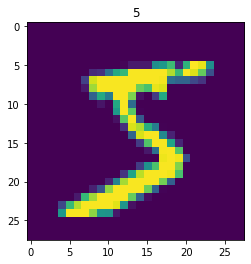

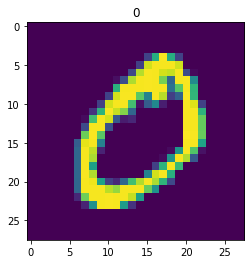

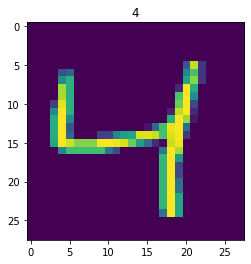

In [3]:
#lets visualize the data
import matplotlib.pyplot as plt

num_sample = 3
for i,data in enumerate(training_data):
  image, label = data
  plt.title(label)
  plt.imshow(image[0].numpy())
  plt.show()
  if i == num_sample-1:
    break

In [4]:
batch_size = 32

#create dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


## 3. Create Model
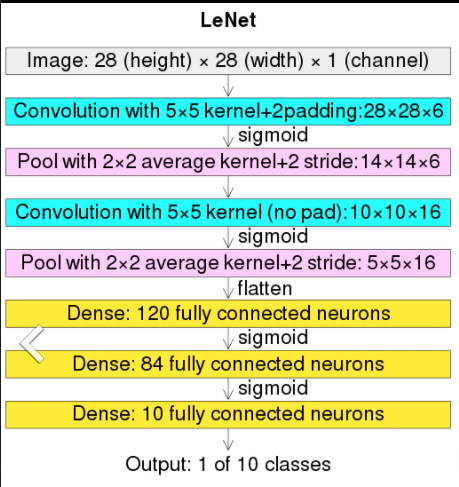

In [5]:
#let's modive it little bit
class LeNet(nn.Module):
  def __init__(self, input_channel=1, num_class=10):
    super().__init__()
    self.input_channel = input_channel
    self.num_class = num_class

    self.feature = nn.Sequential(
        nn.Conv2d(self.input_channel, 32, (5,5), padding=2),
        nn.MaxPool2d((2,2), 2),
        nn.ReLU(),
        nn.Conv2d(32, 64, (5,5)),
        nn.MaxPool2d((2,2), 2),
        nn.ReLU()
    )
    
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(5*5*64, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84,10),
    )

  def forward(self, x):
    return self.fc(self.feature(x))

    return x

In [6]:
model = LeNet()
print(model)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [7]:
#lets initialize loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 6. Create Training Scheme Pytorch

In [8]:
# lets init the model to cuda
model.to('cuda')

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to("cuda"), y.to("cuda")

    pred = model(X)
    loss = loss_fn(pred, y)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to("cuda"), y.to("cuda")
      
      pred = model(X)
      loss = loss_fn(pred, y)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299948  [    0/60000]
loss: 2.311296  [ 3200/60000]
loss: 2.288565  [ 6400/60000]
loss: 2.310678  [ 9600/60000]
loss: 2.298673  [12800/60000]
loss: 2.299096  [16000/60000]
loss: 2.297188  [19200/60000]
loss: 2.291069  [22400/60000]
loss: 2.284990  [25600/60000]
loss: 2.288286  [28800/60000]
loss: 2.292638  [32000/60000]
loss: 2.303639  [35200/60000]
loss: 2.278097  [38400/60000]
loss: 2.281847  [41600/60000]
loss: 2.301125  [44800/60000]
loss: 2.279459  [48000/60000]
loss: 2.287630  [51200/60000]
loss: 2.275825  [54400/60000]
loss: 2.281308  [57600/60000]
Test Error: 
 Accuracy: 20.0%, Avg loss: 2.283192 

Epoch 2
-------------------------------
loss: 2.282122  [    0/60000]
loss: 2.292805  [ 3200/60000]
loss: 2.269172  [ 6400/60000]
loss: 2.289249  [ 9600/60000]
loss: 2.284405  [12800/60000]
loss: 2.284477  [16000/60000]
loss: 2.269886  [19200/60000]
loss: 2.262867  [22400/60000]
loss: 2.257552  [25600/60000]
loss: 2.242122  [28800/60000

## 6. Create using pytorch lightning

In [ ]:
!pip install pytorch-lightning

In [13]:
from pytorch_lightning import LightningModule, Trainer

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [20]:
class LeNet(LightningModule):
  def __init__(self, input_channel=1, num_class=10):
    super().__init__()
    self.input_channel = input_channel
    self.num_class = num_class

    self.feature = nn.Sequential(
        nn.Conv2d(self.input_channel, 32, (5,5), padding=2),
        nn.MaxPool2d((2,2), 2),
        nn.ReLU(),
        nn.Conv2d(32, 64, (5,5)),
        nn.MaxPool2d((2,2), 2),
        nn.ReLU()
    )
    
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(5*5*64, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84,10),
    )

  def forward(self, x):
    return self.fc(self.feature(x))

    return x
  def training_step(self, batch, batch_bn):
    x, y = batch
    loss = loss_fn(self(x), y)
    return loss
  def validation_step(self, batch, batch_bn):
    x, y = batch
    loss = loss_fn(self(x), y)
    return loss
  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=1e-3)

## 7. Train Model pyttorchlightning

In [ ]:
model_pl = LeNet()

trainer = Trainer(
    gpus=1,
    max_epochs=100,
    progress_bar_refresh_rate=20,
)

# Train the model ⚡
trainer.fit(model_pl, train_dataloader, test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | feature | Sequential | 52.1 K
1 | fc      | Sequential | 203 K 
---------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.021     Total estimated

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]